In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

## Importing the data

In [2]:
data = pd.read_csv("neonatal_basic_data.csv")
training_set = data[data['death']!=0]
training_labels = training_set['death']
training_data = training_set[['ga', 'bw']]
test_set = data[data['death']==0]
#test_labels = test_set['death']
test_data = test_set[['ga', 'bw']]

scale the data

In [3]:
scaler = StandardScaler()
training_data_stand = scaler.fit_transform(training_data)
test_data_stand = scaler.fit_transform(test_data)

minmaxscaler = MinMaxScaler()
training_data_minmax = minmaxscaler.fit_transform(training_data)
test_data_minmax = minmaxscaler.fit_transform(test_data)

## Visualization of the class distribution

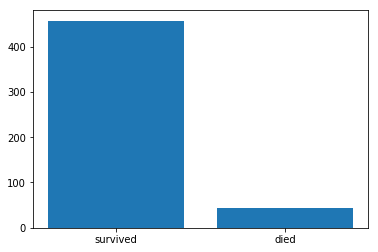

In [4]:
labels = training_labels.as_matrix()
classes, distribution = np.unique(labels, return_counts=True)
plt.bar(classes, distribution)
plt.xticks(classes, ["survived", "died"])
plt.show()

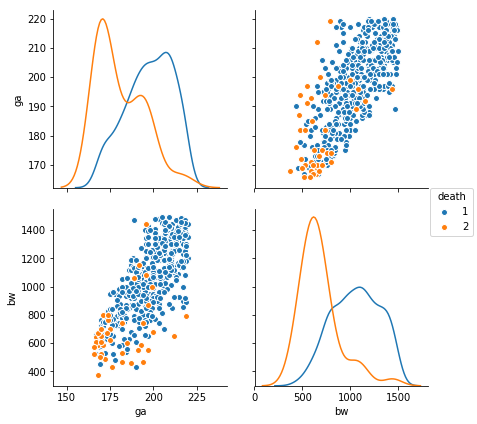

In [5]:
sns.pairplot(training_set[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

### Decision Trees

In [6]:
classifier = DecisionTreeClassifier()
classifier = classifier.fit(training_data_stand, training_labels)
print('score for decision trees: ', classifier.score(training_data_stand, training_labels))
print('f1 measure for decision trees: ', f1_score(training_labels, classifier.predict(training_data_stand),
                                                  average='weighted'))
p = classifier.predict(test_data_stand)

('score for decision trees: ', 0.998)
('f1 measure for decision trees: ', 0.99798932819029251)


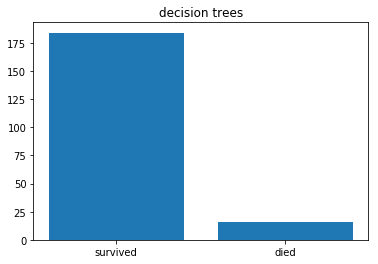

In [7]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('decision trees')
plt.xticks(classes, ["survived", "died"])
plt.show()

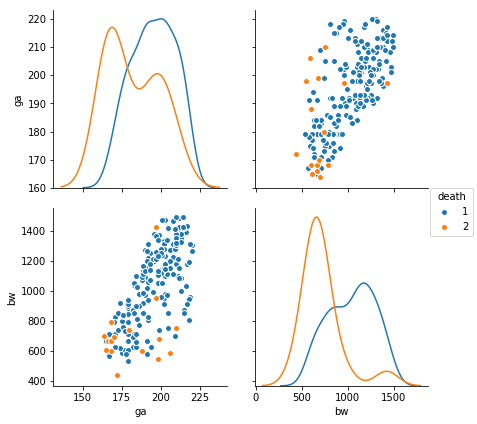

In [8]:
dt_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(dt_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

### SVM

In [9]:
SVM = svm.SVC(class_weight='balanced', kernel='rbf')
SVM.fit(training_data_stand, training_labels)
print('score for SVM: ', SVM.score(training_data_stand, training_labels))
print('f1 measure for SVM: ', f1_score(training_labels, SVM.predict(training_data_stand),
                                                  average='weighted'))
p = SVM.predict(test_data_stand)

('score for SVM: ', 0.85599999999999998)
('f1 measure for SVM: ', 0.87969506549788246)


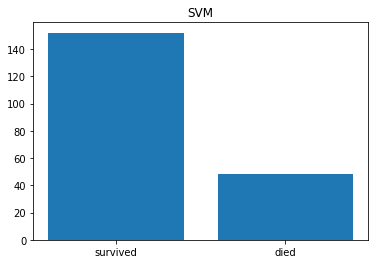

In [10]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('SVM')
plt.xticks(classes, ["survived", "died"])
plt.show()

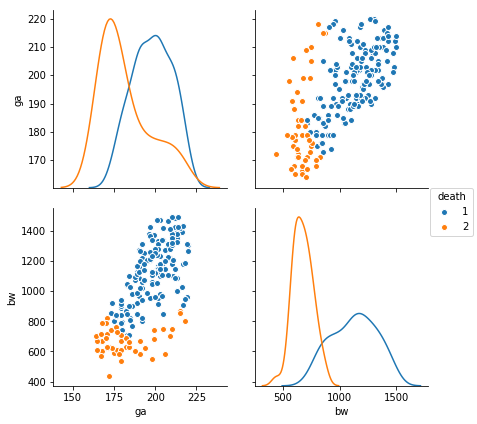

In [11]:
svm_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(svm_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

### Logistic Regression

In [12]:
LogReg = LogisticRegression()
LogReg.fit(training_data_stand, training_labels)
print('score for logistic regression: ', LogReg.score(training_data_stand, training_labels))
print('f1 measure for logistic regression: ', f1_score(training_labels, LogReg.predict(training_data_stand),
                                                  average='weighted'))
p = LogReg.predict(test_data_stand)

('score for logistic regression: ', 0.92000000000000004)
('f1 measure for logistic regression: ', 0.89764936183540833)


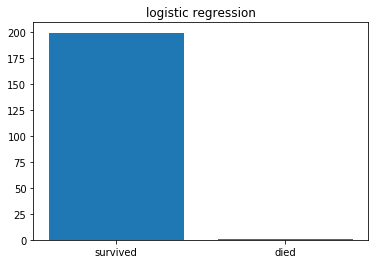

In [13]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('logistic regression')
plt.xticks(classes, ["survived", "died"])
plt.show()

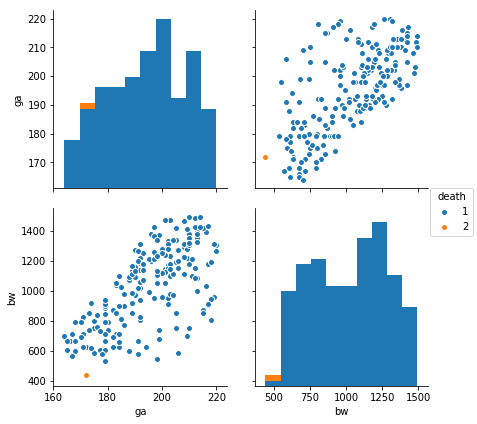

In [14]:
lg_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(lg_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             #, diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

### Naive Bayes

In [15]:
MNB = MultinomialNB()
MNB.fit(training_data_minmax, training_labels)
print('score for Multinomial Naive Bayes: ', MNB.score(training_data_minmax, training_labels))
print('f1 measure for Multinomial Naive Bayes: ', f1_score(training_labels, MNB.predict(training_data_minmax),
                                                  average='weighted'))
p = MNB.predict(test_data_minmax)

('score for Multinomial Naive Bayes: ', 0.91400000000000003)
('f1 measure for Multinomial Naive Bayes: ', 0.87293207941483797)


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


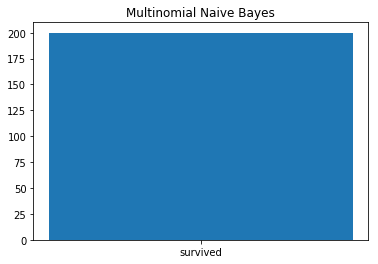

In [16]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('Multinomial Naive Bayes')
plt.xticks(classes, ["survived", "died"])
plt.show()

In [17]:
GNB = GaussianNB()
GNB.fit(training_data_minmax, training_labels)
print('score for logistic regression: ', GNB.score(training_data_minmax, training_labels))
print('f1 measure for logistic regression: ', f1_score(training_labels, GNB.predict(training_data_minmax),
                                                  average='weighted'))
p = GNB.predict(test_data_minmax)

('score for logistic regression: ', 0.89200000000000002)
('f1 measure for logistic regression: ', 0.89950845015066172)


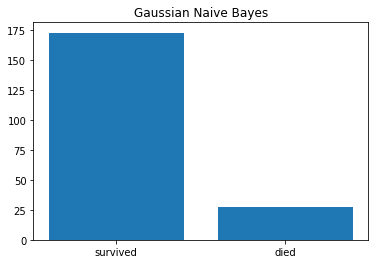

In [18]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('Gaussian Naive Bayes')
plt.xticks(classes, ["survived", "died"])
plt.show()

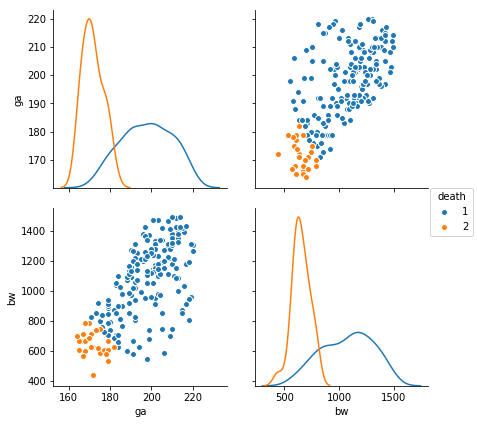

In [19]:
gnb_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(gnb_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

### Gaussian Processes

In [20]:
kernel = 1.0 * RBF(length_scale=1.0)
gp = GaussianProcessClassifier(kernel=kernel, optimizer=None)
gp.fit(training_data, training_labels)
p = gp.predict(test_data)

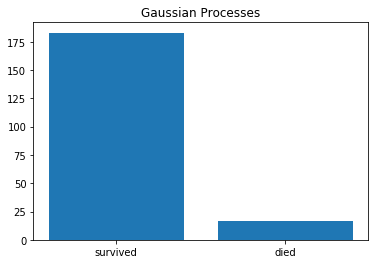

In [21]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('Gaussian Processes')
plt.xticks(classes, ["survived", "died"])
plt.show()

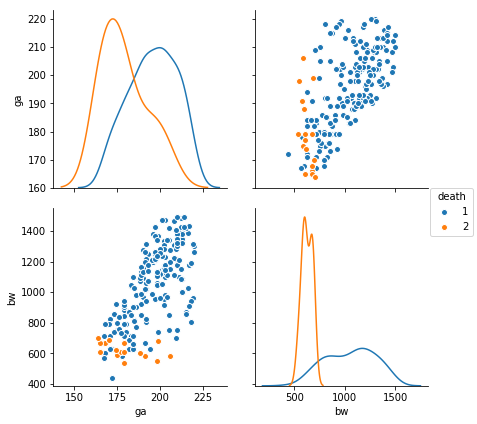

In [22]:
gp_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(gp_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

In [26]:
pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix()
    , 'death_dt':dt_pred['death'], 'death_svm':svm_pred['death']
    , 'death_gnb':gnb_pred['death'], 'death_gp':gp_pred['death']})
pred

,bw,death_dt,death_gnb,death_gp,death_svm,ga
0,1370,1,1,1,1,197
1,600,2,2,1,2,168
2,1180,1,1,1,1,217
3,1335,1,1,1,1,202
4,710,1,1,1,1,183
5,1014,1,1,1,1,191
6,1405,1,1,1,1,213
7,1350,1,1,1,1,213
8,1325,1,1,1,1,213
9,1250,1,1,1,1,193


In [35]:
pred.loc[(pred['death_dt'] == 2) | (pred['death_svm']==2) | (pred['death_gp'] == 2) | (pred['death_gnb']==2)]

,bw,death_dt,death_gnb,death_gp,death_svm,ga
1,600,2,2,1,2,168
14,1425,2,1,1,1,197
21,670,2,2,2,2,166
28,870,1,1,1,2,215
31,610,2,2,2,2,165
32,590,1,2,2,2,175
39,825,1,1,1,2,171
41,670,2,2,2,2,168
42,630,1,2,1,2,182
47,670,1,2,2,2,165
